In [1]:
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import json
from IPython.display import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

In [2]:
new_size = 448
N = 7
num_of_clusters = 13
slice_size = new_size // N
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)
device

device(type='cuda', index=0)

In [3]:
path_to_imgs = '/kaggle/input/textocr-text-extraction-from-images-dataset/train_val_images'
path = os.path.join(path_to_imgs, r'train_images')
img_ids = os.listdir(path)
files = [os.path.join(path, f) for f in img_ids]
path_to_bb_file = '/kaggle/input/textocr-text-extraction-from-images-dataset'
path_to_bounding_boxes = os.path.join(path_to_bb_file, r'TextOCR_0.1_train.json')
with open(path_to_bounding_boxes, 'r') as f:
    bounding_boxes = json.load(f)

In [4]:
def pad_img(img):
    """
    Pad image to square using pytorch, to the right or bottom
    """
    h, w = img.shape[-2:]
    if h > w:
        pad = h - w
        img = transforms.Pad((0, 0, pad, 0))(img)
    elif w > h:
        pad = w - h
        img = transforms.Pad((0, 0, 0, pad))(img)
    return img

def resize_img(img, size):
    """
    Resize image to square using pytorch
    """
    img = transforms.Resize(size, antialias=True)(img)
    return img

torch.Size([3, 768, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 448, 448])


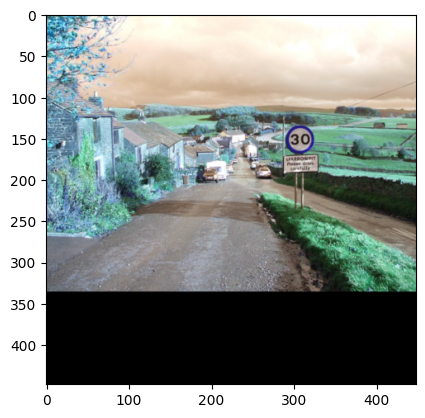

In [5]:
def make_it_cv2(img):
    img = img.permute(1, 2, 0)
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

img = read_image(files[7])
print(img.shape)
img = pad_img(img)
print(img.shape)
img = resize_img(img, (new_size, new_size))
print(img.shape)
img = make_it_cv2(img)
cv2.imwrite('test.jpg', img)
plt.imshow(img)

In [6]:
def pre_process_image(img):
    h, w = img.shape[-2:]
    max_shape = max(h, w)
    ratio = new_size / max_shape
    img = pad_img(img)
    img = resize_img(img, (new_size, new_size))
    img = img / 255.
    return img, ratio


tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.0000, 0.0000, 0.0000],
         [0.4392, 0.4392, 0.4392,  ..., 0.0000, 0.0000, 0.0000],
         [0.4392, 0.4392, 0.4392,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.2510, 0.2510, 0.2510,  ..., 0.0000, 0.0000, 0.0000],
         [0.2510, 0.2510, 0.2510,  ..., 0.0000, 0.0000, 0.0000],
         [0.2549, 0.2549, 0.2549,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.4431, 0.4392, 0.4353,  ..., 0.0000, 0.0000, 0.0000],
         [0.4431, 0.4392, 0.4392,  ..., 0.0000, 0.0000, 0.0000],
         [0.4392, 0.4392, 0.4392,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.2314, 0.2314, 0.2353,  ..., 0.0000, 0.0000, 0.0000],
         [0.2471, 0.2471, 0.2510,  ..., 0.0000, 0.0000, 0.0000],
         [0.2588, 0.2627, 0.2627,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.4157, 0.4314, 0.4549,  ..., 0.0000, 0.0000, 0.0000],
         [0.4196, 0.4314, 0.4510,  ..., 0.0000, 0.0000, 0.0000],
         [0.4275, 0.4353, 0.4431,  ..., 0.0000, 0.0000, 0.

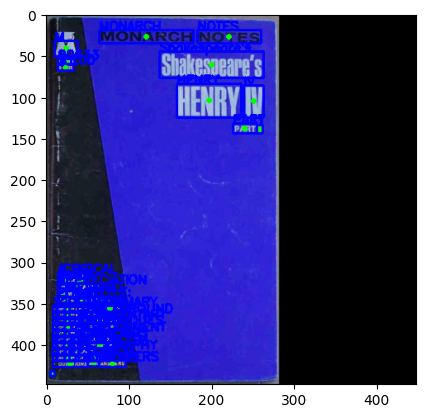

In [7]:
def get_bbox_resized(prebb, ratio):
    bb = prebb.copy()
    bb[0] = bb[0] * ratio
    bb[1] = bb[1] * ratio
    bb[2] = bb[2] * ratio
    bb[3] = bb[3] * ratio
    return bb
def get_middle_point(bb):
    x = (bb[0] + bb[2])/2
    y = (bb[1] + bb[3])/2
    return [x, y]
img_idx = 47
img_anns = bounding_boxes['imgToAnns'][img_ids[img_idx][:-4]]
img = read_image(files[img_idx])
img, ratio = pre_process_image(img)
print(img)
img = make_it_cv2(img)
for i in range(len(img_anns)):
    ann = bounding_boxes['anns'][img_anns[i]]
    points = ann['bbox']
    x1, y1, x2, y2 = points[0], points[1], points[2] + points[0], points[3] + points[1]
    x1, y1, x2, y2 = get_bbox_resized([x1, y1, x2, y2], ratio)
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    middle_point = get_middle_point([x1, y1, x2, y2])
    cv2.circle(img, (int(middle_point[0]), int(middle_point[1])), 2, (0, 255, 0), 2)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    cv2.putText(img, str(ann['utf8_string']), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
cv2.imwrite('img_with_annotations.jpg', img)
plt.imshow(img)

In [8]:
idx_to_remove = []
for img_idx in range(len(files)):
    try:
        img_anns = bounding_boxes['imgToAnns'][img_ids[img_idx][:-4]]
    except KeyError:
        idx_to_remove.append(img_idx)
        continue

print('Number of images before removing images with no annotations: {}'.format(len(files)))
files = [i for j, i in enumerate(files) if j not in idx_to_remove]
img_ids = [i for j, i in enumerate(img_ids) if j not in idx_to_remove]
print('Number of images after removing images with no annotations: {}'.format(len(files)))

Number of images before removing images with no annotations: 25119
Number of images after removing images with no annotations: 21778


In [9]:
text_heights = []
text_widths = []
for ann in bounding_boxes['anns']:
    w = bounding_boxes['anns'][ann]['bbox'][2]
    h = bounding_boxes['anns'][ann]['bbox'][3]
    img_width = bounding_boxes['imgs'][bounding_boxes['anns'][ann]['image_id']]['width']
    img_height = bounding_boxes['imgs'][bounding_boxes['anns'][ann]['image_id']]['height']
    rat = new_size / max(img_width, img_height)
    text_heights.append(h * rat)
    text_widths.append(w * rat)

In [10]:
from sklearn.cluster import KMeans
X = np.array(list(zip(text_widths, text_heights))).reshape(len(text_widths), 2)
kmeans = KMeans(n_clusters=num_of_clusters)
kmeans.fit(X)
centers = kmeans.cluster_centers_

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [11]:
files = np.array(files)
img_ids = np.array(img_ids)
max_point_in_slice = 1
os.chdir('/kaggle')
os.mkdir('tmp')
os.chdir('tmp')
os.mkdir('data')
os.chdir('data')
os.mkdir('features')
os.mkdir('labels')

data_set_size = 6000

def create_dataset(size=len(files)):
    for idx in range(size):
        img_path = files[idx]
        image = read_image(img_path)
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)
        elif image.shape[0] != 3:
            image = image[:3]
        image, ratio = pre_process_image(image)

        slices = np.zeros((N*N, num_of_clusters, 5))
        slices_counts = np.zeros((N*N, num_of_clusters), dtype=np.int32)
        img_anns = bounding_boxes['imgToAnns'][img_ids[idx][:-4]]
        for i in range(len(img_anns)):
            ann = bounding_boxes['anns'][img_anns[i]]
            points = ann['bbox']
            x1, y1, x2, y2 = points[0], points[1], points[2] + points[0], points[3] + points[1]
            x1, y1, x2, y2 = get_bbox_resized([x1, y1, x2, y2], ratio)
            middle_point = get_middle_point([x1, y1, x2, y2])
            x_slice, y_slice = int(middle_point[0] / slice_size), int(middle_point[1] / slice_size)
            if ann['utf8_string'] != '.':
                cluster_idx = kmeans.predict([[(x2 - x1) , (y2 - y1)]])
                if slices_counts[y_slice * N + x_slice][cluster_idx] >= max_point_in_slice:
                    continue
                mid_x, mid_y = middle_point[0] - x_slice * slice_size, middle_point[1] - y_slice * slice_size
                mid_x, mid_y = mid_x / slice_size, mid_y / slice_size
                w_raw , h_raw = (x2 - x1), (y2 - y1)
                p_w , p_h = centers[cluster_idx][0]
                w, h = w_raw / p_w, h_raw / p_h
                slices[y_slice * N + x_slice][cluster_idx] = np.array([1, mid_x, mid_y, w, h])
                slices_counts[y_slice * N + x_slice][cluster_idx] += 1
        label = slices
        image = image.float()
        label = torch.tensor(label)
        label = label.float()
        torch.save(image, os.path.join('features', img_ids[idx][:-4] + '.pt'))
        torch.save(label, os.path.join('labels', img_ids[idx][:-4] + '.pt'))
        print(f'\r{idx + 1}/{len(files)}', end='', flush=True)


create_dataset(data_set_size)

6000/21778

In [12]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random

class CustomImageDataset(Dataset):
    def __init__(self, img_ids):
        self.img_ids = img_ids

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        feature = torch.load(os.path.join('features', self.img_ids[idx][:-4] + '.pt'))
        label = torch.load(os.path.join('labels', self.img_ids[idx][:-4] + '.pt'))
        return feature, label
    
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)
    
dataset = CustomImageDataset(img_ids[:data_set_size])
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [5000, data_set_size - 5000])
batch_size = 32
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=os.cpu_count(),
                              pin_memory=True,
                              worker_init_fn=seed_worker,
                              generator=g)
test_dataloader = DataLoader(val_dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             num_workers=os.cpu_count(),
                             pin_memory=True,
                             worker_init_fn=seed_worker,
                             generator=g)
print(len(train_dataloader))
print(len(test_dataloader))

157
32


In [14]:
class VggBlock(nn.Module):
    def __init__(self, in_ch, out_ch, maxpool=True):
        super(VggBlock, self).__init__()
        block = []
        block.append(nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False))
        block.append(nn.BatchNorm2d(out_ch))
        block.append(nn.LeakyReLU(0.1, inplace=True))
        block.append(nn.Conv2d(out_ch, out_ch, kernel_size=1, padding=0, bias=False))
        block.append(nn.BatchNorm2d(out_ch))
        block.append(nn.LeakyReLU(0.1, inplace=True))
        if maxpool:
            block.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
        block_modules = nn.ModuleList(block)
        self.block = nn.Sequential(*block_modules)

    def forward(self, x):
        x = self.block(x)
        return x
    
class Vgg(nn.Module):
    def __init__(self):
        super(Vgg, self).__init__()
        self.conv1 = VggBlock(3, 64)
        self.conv2 = VggBlock(64, 128)
        self.conv3 = VggBlock(128, 256)
        self.conv4 = VggBlock(256, 512)
        self.conv5 = VggBlock(512, 512)
        self.conv6 = VggBlock(512, 512, False)
        
    def forward(self, x):
        x = self.conv1(x)
        x1 = self.conv2(x)
        x2 = self.conv3(x1)
        x3 = self.conv4(x2)
        x4 = self.conv5(x3)
        x5 = self.conv6(x4)
        return x1, x2, x3, x4, x5
    
class Upconv(nn.Module):
    def __init__(self,in_ch, out_ch, upsample=True):
        super(Upconv, self).__init__()
        self.upsample = upsample
        layer = []
        layer.append(nn.Conv2d(in_ch, out_ch*2, kernel_size=1, padding=0, bias=False))
        layer.append(nn.BatchNorm2d(out_ch*2))
        layer.append(nn.LeakyReLU(0.1, inplace=True))
        layer.append(nn.Conv2d(out_ch*2, out_ch, kernel_size=3, padding=1, bias=False))
        layer.append(nn.BatchNorm2d(out_ch))
        layer.append(nn.LeakyReLU(0.1, inplace=True))
        
        layer_modules = nn.ModuleList(layer)
        self.layer = nn.Sequential(*layer_modules)
        
    def forward(self, x):
        x = self.layer(x)
        if self.upsample:
            size = x.size()[2:]
            size = (size[0]*2, size[1]*2)
            x = nn.functional.interpolate(x, size=size, mode='bilinear', align_corners=False)
        return x


class Model(nn.Module):
    def __init__(self, img_size, N, max_points_in_slice):
        super(Model, self).__init__()
        self.img_size = img_size
        self.N = N
        self.max_points_in_slice = max_points_in_slice
        self.vgg = Vgg()
        self.upconv1 = Upconv(1024, 256)
        self.upconv2 = Upconv(768, 128)
        self.upconv3 = Upconv(384, 64)
        self.upconv4 = Upconv(192, 32, False)
        self.downconv1 = VggBlock(96, 128)
        self.downconv2 = VggBlock(256, 512)
        self.downconv3 = VggBlock(768, 1024)
        self.downconv4 = VggBlock(1024, self.max_points_in_slice*5)

    def forward(self, x):
        vgg_outputs = self.vgg(x)
        y1 = torch.cat([vgg_outputs[3], vgg_outputs[4]], dim=1)
        y1 = self.upconv1(y1)
        
        y2 = torch.cat([y1, vgg_outputs[2]], dim=1)
        y2 = self.upconv2(y2)
        
        y3 = torch.cat([y2, vgg_outputs[1]], dim=1)
        y3 = self.upconv3(y3)
        
        y4 = torch.cat([y3, vgg_outputs[0]], dim=1)
        y4 = self.upconv4(y4)
                
        y = torch.cat([y4, y3], dim=1)
        y = self.downconv1(y)
        
        y = torch.cat([y, y2], dim=1)
        y = self.downconv2(y)
        
        y = torch.cat([y, y1], dim=1)
        y = self.downconv3(y)
        
        y = self.downconv4(y)
                
        y = y.permute(0, 2, 3, 1)
        y = y.reshape(-1, self.N*self.N, self.max_points_in_slice, 5)
        return y

    def predict(self, x):
        x = self.forward(x)
        x[:, :, :, 0] = torch.sigmoid(x[:, :, :, 0])
        x[:, :, :, 1:3] = torch.sigmoid(x[:, :, :, 1:3])
        x[:, :, :, 3:5] = torch.exp(x[:, :, :, 3:5])
        return x



In [15]:
 class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        scale = 0.05

        noob_gamma = 1
        box_gamma = 7
        size_gamma = 1
        conf_gamma = 8
        self.noob_gamma, self.box_gamma, self.size_gamma, self.conf_gamma = noob_gamma*scale, box_gamma*scale, size_gamma*scale, conf_gamma*scale

    def forward(self, inputs, targets):
        input_confidences = inputs[:, :, :, 0]
        target_confidences = targets[:, :, :, 0]
        detection_mask = target_confidences > 0.5
        no_object_mask = target_confidences <= 0.5
        
        # Confidence loss
        confidence_loss = torch.nn.functional.mse_loss(input_confidences[detection_mask], target_confidences[detection_mask],
                                                       reduction='sum')
        no_confidence_loss = torch.nn.functional.mse_loss(input_confidences[no_object_mask], target_confidences[no_object_mask],
                                                          reduction='sum')

        # Bounding box loss
        input_boxes = inputs[:, :, :, 1:3]
        target_boxes = targets[:, :, :, 1:3]
        box_loss = torch.nn.functional.mse_loss(input_boxes[detection_mask], target_boxes[detection_mask], reduction='sum')

        # Size loss
        input_sizes = inputs[:, :, :, 3:5]
        target_sizes = targets[:, :, :, 3:5]
        target_sizes = torch.log(target_sizes)
        size_loss = torch.nn.functional.mse_loss(input_sizes[detection_mask], target_sizes[detection_mask], reduction='sum')
        
        
        loss = self.noob_gamma*no_confidence_loss + self.conf_gamma*confidence_loss + self.box_gamma*box_loss + self.size_gamma*size_loss
        return loss

In [16]:
def show_progress(epoch, step, total_steps, loss, width=30, bar_char='█', empty_char='░'):
    print('\r', end='')
    progress = ""
    for i in range(width):
        progress += bar_char if i < int(step / total_steps * width) else empty_char
    print(f"epoch:{epoch + 1} [{progress}] {step}/{total_steps} loss: {loss:.4f}", end='')
    if step >= total_steps - 1:
        print()


In [17]:
epochs = 30
torch.cuda.empty_cache()
model = Model(new_size, N, num_of_clusters)
model = nn.DataParallel(model, device_ids=[0, 1])
model.to(device)
loss = Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=0.0005, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 20], gamma=0.1)


In [18]:
model.train()
for epoch in range(0, epochs):
    running_loss = 0.0
    for i, (x, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.autocast('cuda'):
            output = model.forward(x)
            loss_val = loss(output, y)
        loss_val.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        x.detach()
        y.detach()
        with torch.no_grad():
            running_loss += loss_val.item()
            show_progress(epoch, i, len(train_dataloader), running_loss/(i + 1))
    scheduler.step()

epoch:1 [█████████████████████████████░] 156/157 loss: 194.1007
epoch:2 [█████████████████████████████░] 156/157 loss: 108.8213
epoch:3 [█████████████████████████████░] 156/157 loss: 99.03029
epoch:4 [█████████████████████████████░] 156/157 loss: 93.0183
epoch:5 [█████████████████████████████░] 156/157 loss: 89.2455
epoch:6 [█████████████████████████████░] 156/157 loss: 85.3409
epoch:7 [█████████████████████████████░] 156/157 loss: 82.4423
epoch:8 [█████████████████████████████░] 156/157 loss: 80.1523
epoch:9 [█████████████████████████████░] 156/157 loss: 78.2537
epoch:10 [█████████████████████████████░] 156/157 loss: 75.4926
epoch:11 [█████████████████████████████░] 156/157 loss: 73.1543
epoch:12 [█████████████████████████████░] 156/157 loss: 71.9542
epoch:13 [█████████████████████████████░] 156/157 loss: 69.4135
epoch:14 [█████████████████████████████░] 156/157 loss: 68.6013
epoch:15 [█████████████████████████████░] 156/157 loss: 66.3084
epoch:16 [█████████████████████████████░] 156/

In [19]:
os.chdir('..')
os.chdir('..')
os.chdir('working')
print(os.getcwd())
torch.save(model.state_dict(), '/saved_model.pth')

/kaggle/working


In [23]:
# validation
os.chdir('..')
os.chdir('tmp')
os.chdir('data')
model.eval()
total_val_loss = 0.0
with torch.no_grad():
    for i, (x, y) in enumerate(test_dataloader):
        x = x.to(device)
        y = y.to(device)
        output = model.forward(x)
        loss_val = loss(output, y)
        x.detach()
        y.detach()
        total_val_loss += loss_val.item()
    average_val_loss = total_val_loss / len(test_dataloader)

print(f'Validation Loss: {average_val_loss}')

Validation Loss: 80.05892407894135


In [24]:
model.eval()
test_features, test_labels = next(iter(test_dataloader))
test_features = test_features.to(device)
with torch.autocast('cuda'):
    predictions = model.forward(test_features)
predictions[:, :, :, 3:5] = torch.exp(predictions[:, :, :, 3:5])
predictions = predictions.to(device)
idx = 0

In [26]:
def unify_bounding_boxes(bboxes, iou_threshold):
    # Sort the bounding boxes by probability in descending order.
    bboxes.sort(key=lambda bbox: bbox[0], reverse=True)

    unified_bboxes = []
    while len(bboxes) > 0:
        current_bbox = bboxes[0]
        remaining_bboxes = []

        for bbox in bboxes[1:]:
            iou = calculate_iou(current_bbox, bbox)
            if iou < iou_threshold:
                remaining_bboxes.append(bbox)
            else:
                current_bbox = merge_bboxes(current_bbox, bbox)

        unified_bboxes.append(current_bbox)
        bboxes = remaining_bboxes

    return unified_bboxes

def calculate_iou(bbox1, bbox2):
    x1_1, y1_1, x2_1, y2_1 = bbox1[1], bbox1[2], bbox1[3], bbox1[4]
    x1_2, y1_2, x2_2, y2_2 = bbox2[1], bbox2[2], bbox2[3], bbox2[4]

    # Calculate the intersection coordinates.
    x1_i = max(x1_1, x1_2)
    y1_i = max(y1_1, y1_2)
    x2_i = min(x2_1, x2_2)
    y2_i = min(y2_1, y2_2)

    # Calculate the area of intersection.
    intersection_area = max(0, x2_i - x1_i) * max(0, y2_i - y1_i)

    # Calculate the areas of the two bounding boxes.
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)

    # Calculate the union area.
    union_area = area1 + area2 - intersection_area

    # Calculate the IoU.
    iou = intersection_area / union_area

    return iou

def merge_bboxes(bbox1, bbox2):
    x1_1, y1_1, x2_1, y2_1 = bbox1[1], bbox1[2], bbox1[3], bbox1[4]
    x1_2, y1_2, x2_2, y2_2 = bbox2[1], bbox2[2], bbox2[3], bbox2[4]

    # Merge the bounding boxes by taking the minimum x and y coordinates as (x1, y1) and
    # the maximum x and y coordinates as (x2, y2).
    merged_bbox = (bbox1[0], min(x1_1, x1_2), min(y1_1, y1_2), max(x2_1, x2_2), max(y2_1, y2_2))

    return merged_bbox

32


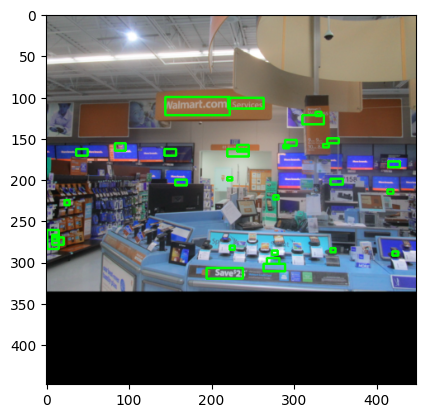

In [59]:
# idx -= 1
prediction = predictions[idx]
test_label = test_labels[idx]
torch.set_printoptions(profile="default")
prediction = prediction.cpu()
prediction = prediction.view(N, N, num_of_clusters*5)
test_features = test_features.cpu()
test_label = test_label.view(N, N, num_of_clusters*5)
img = make_it_cv2(test_features[idx])
bounding_boxes_preds = []
for i in range(N):
    for j in range(N):
        for k in range(num_of_clusters):
            if prediction[i][j][k*5] > 0.5:
                w = prediction[i][j][k*5+3]*centers[k][0]
                h = prediction[i][j][k*5+4]*centers[k][1]
                x = prediction[i][j][k*5+1]*slice_size + j*slice_size - w/2
                y = prediction[i][j][k*5+2]*slice_size + i*slice_size - h/2
                x1, y1, x2, y2 = int(x), int(y), int(x+w), int(y+h)
                bounding_boxes_preds.append([prediction[i][j][k*5], x1, y1, x2, y2])

for box in unify_bounding_boxes(bounding_boxes_preds, 0.2):
    _, x1, y1, x2, y2 = box
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
bounding_boxes_preds = []
for i in range(N):
    for j in range(N):
        for k in range(num_of_clusters):
            if test_label[i][j][k*5] > 0.8:
                w = test_label[i][j][k*5+3]*centers[k][0]
                h = test_label[i][j][k*5+4]*centers[k][1]
                x = test_label[i][j][k*5+1]*slice_size + j*slice_size - w/2
                y = test_label[i][j][k*5+2]*slice_size + i*slice_size - h/2
                x1, y1, x2, y2 = int(x), int(y), int(x+w), int(y+h)
                bounding_boxes_preds.append([x1, y1, x2, y2])

for box in bounding_boxes_preds:
    x1, y1, x2, y2 = box
#     cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
idx += 1
cv2.imwrite('test.jpg', img)
plt.imshow(img)
print(idx)